<a href="https://colab.research.google.com/github/olyaee/3D_semgentation/blob/master/3D_MRI_Brain_Tumor_Segmentation_Using_Autoencoder_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [2]:
!pip install simpleitk
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
import glob  # For populating the list of files
import matplotlib.pyplot as plt
from scipy.ndimage import zoom  # For resizing

import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.layers import Conv3D, Activation, Add, UpSampling3D, Lambda, Dense
from tensorflow.keras.layers import Input, Reshape, Flatten, Dropout, SpatialDropout3D
from tensorflow.keras.optimizers import Adam as adam
from tensorflow.keras.models import Model
from tensorflow_addons.layers import GroupNormalization

In [0]:
DIR_DATA="/drive/My Drive/data/BraTS/Brats17TrainingData/"
ORIGINAL_SHAPE = (155, 240, 240)
INPUT_SHAPE = (80, 96, 64)
EPOCHS = 10

In [5]:
# list_path_t2 = glob.glob(data_dir + '*GG/*/*t2.nii.gz')
# len_data = len(list_path_t2)
# print('len_data', len_data)

# Get a list of files for all modalities individually
list_path_t1 = glob.glob(DIR_DATA + "*GG/*/Brats*t1.nii.gz")
list_path_t2 = glob.glob(DIR_DATA + '*GG/*/*t2.nii.gz')
list_path_flair = glob.glob(DIR_DATA + '*GG/*/*flair.nii.gz')
list_path_t1ce = glob.glob(DIR_DATA + '*GG/*/*t1ce.nii.gz')
list_path_seg = glob.glob(DIR_DATA + '*GG/*/*seg.nii.gz')  # Ground Truth 

len_data = len(list_path_t1)
print('len_data', len_data)

assert len(list_path_t1)==len(list_path_t2)==len(list_path_flair)==len(list_path_t1ce)==len(list_path_seg)

len_data 285


In [0]:
def resize(img, shape, mode='constant', orig_shape=ORIGINAL_SHAPE):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )
    
    # Resize to the given shape
    return zoom(img, factors, mode=mode)

def preprocess(img, out_shape=None):
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    # Normalize the image
    mean = tf.math.reduce_mean(img)
    std = tf.math.reduce_std(img)
    img = (img - mean) / std
    return img


def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET — label 1)
    """
    ncr = tf.cast(img == 1, tf.float32)  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    ed = tf.cast(img == 2, tf.float32)   # Peritumoral Edema (ED)
    et = tf.cast(img == 4, tf.float32)   # GD-enhancing Tumor (ET)

    img = tf.stack([ncr, ed, et])
    return img

In [0]:
def read_path(list_path, shape=None):
  def f():
    # random.shuffle(list_path)
    for path in list_path:
      # yield path
      img = sitk.GetArrayFromImage(sitk.ReadImage(path))
      if shape is not None:
        img = resize(img, shape, mode='constant')
    
      yield img
  return f

# INPUT_SHAPE = ORIGINAL_SHAPExxx

ds_t1 = tf.data.Dataset.from_generator(read_path(list_path_t1, INPUT_SHAPE), tf.float32, output_shapes=INPUT_SHAPE).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_t2 = tf.data.Dataset.from_generator(read_path(list_path_t2, INPUT_SHAPE), tf.float32, output_shapes=INPUT_SHAPE).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_flair = tf.data.Dataset.from_generator(read_path(list_path_flair, INPUT_SHAPE), tf.float32, output_shapes=INPUT_SHAPE).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_t1ce = tf.data.Dataset.from_generator(read_path(list_path_t1ce, INPUT_SHAPE), tf.float32, output_shapes=INPUT_SHAPE).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_input = tf.data.Dataset.zip((ds_t1, ds_t2, ds_flair, ds_t1ce))
ds_input = ds_input.map(lambda t1, t2, flair, t1ce: tf.stack((t1, t2, flair, t1ce), axis=0), num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_label = tf.data.Dataset.from_generator(read_path(list_path_seg, INPUT_SHAPE), tf.float32, output_shapes=INPUT_SHAPE)
# ds_label = tf.data.Dataset.from_generator(read_path(list_path_seg, INPUT_SHAPE), tf.uint8, output_shapes=INPUT_SHAPE)
ds_label = ds_label.map(preprocess_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_zipped = tf.data.Dataset.zip((ds_input, ds_label))
# ds = ds_zipped.shuffle(len_data,reshuffle_each_iteration=True).repeat(1).batch(1)
ds = ds_zipped.repeat(1).batch(1)

In [0]:
def display(data, num_ch=3, slice=45):
  if num_ch==4:
    titles = ['t1', 't2', 'flair', 't1ce']
  elif num_ch==3:
    titles = ['ncr', 'ed', 'et']
  plt.figure(figsize=(15, 15))
  for i in range(num_ch):
    plt.subplot(1, num_ch, i+1)
    plt.title(titles[i])
    plt.imshow(data[0, i, slice, :, :])
    plt.axis('off')
  plt.show()


(1, 4, 80, 96, 64)
(1, 3, 80, 96, 64)


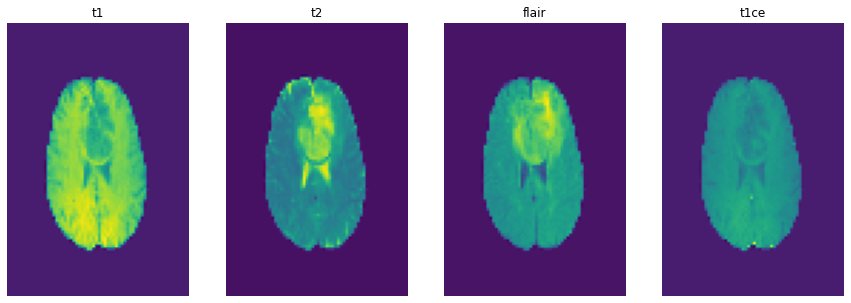

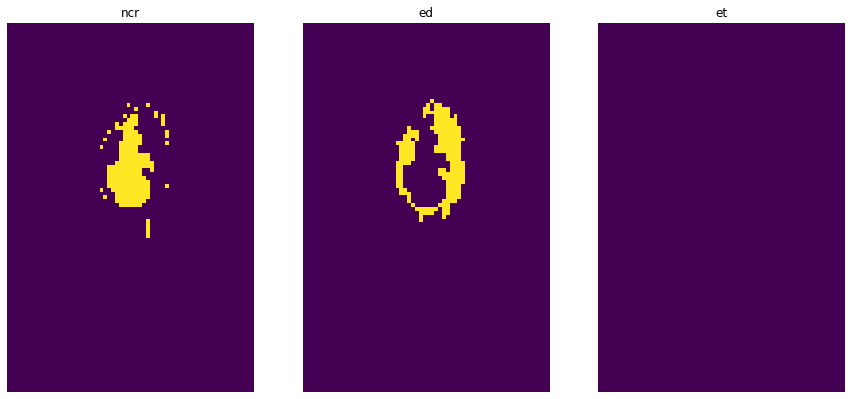

In [9]:
sample_input, sample_label = next(iter(ds_zipped.batch(1)))
print(sample_input.shape)
print(sample_label.shape)
display(sample_input, num_ch=4)
display(sample_label, num_ch=3)

In [0]:
def green_block(inp, filters, data_format='channels_first', name=None):
    """
    green_block(inp, filters, name=None)
    ------------------------------------
    Implementation of the special residual block used in the paper. The block
    consists of two (GroupNorm --> ReLu --> 3x3x3 non-strided Convolution)
    units, with a residual connection from the input `inp` to the output. Used
    internally in the model. Can be used independently as well.
    Parameters
    ----------
    `inp`: An keras.layers.layer instance, required
        The keras layer just preceding the green block.
    `filters`: integer, required
        No. of filters to use in the 3D convolutional block. The output
        layer of this green block will have this many no. of channels.
    `data_format`: string, optional
        The format of the input data. Must be either 'chanels_first' or
        'channels_last'. Defaults to `channels_first`, as used in the paper.
    `name`: string, optional
        The name to be given to this green block. Defaults to None, in which
        case, keras uses generated names for the involved layers. If a string
        is provided, the names of individual layers are generated by attaching
        a relevant prefix from [GroupNorm_, Res_, Conv3D_, Relu_, ], followed
        by _1 or _2.
    Returns
    -------
    `out`: A keras.layers.Layer instance
        The output of the green block. Has no. of channels equal to `filters`.
        The size of the rest of the dimensions remains same as in `inp`.
    """
    inp_res = Conv3D(
        filters=filters,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format=data_format,
        name=f'Res_{name}' if name else None)(inp)

    # axis=1 for channels_first data format
    # No. of groups = 8, as given in the paper
    x = GroupNormalization(
        groups=8,
        axis=1 if data_format == 'channels_first' else 0,
        name=f'GroupNorm_1_{name}' if name else None)(inp)
    x = Activation('relu', name=f'Relu_1_{name}' if name else None)(x)
    x = Conv3D(
        filters=filters,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format=data_format,
        name=f'Conv3D_1_{name}' if name else None)(x)

    x = GroupNormalization(
        groups=8,
        axis=1 if data_format == 'channels_first' else 0,
        name=f'GroupNorm_2_{name}' if name else None)(x)
    x = Activation('relu', name=f'Relu_2_{name}' if name else None)(x)
    x = Conv3D(
        filters=filters,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format=data_format,
        name=f'Conv3D_2_{name}' if name else None)(x)

    out = Add(name=f'Out_{name}' if name else None)([x, inp_res])
    return out


# From keras-team/keras/blob/master/examples/variational_autoencoder.py
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_var) * epsilon


def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[-3,-2,-1])
    dn = tf.reduce_sum(tf.square(y_true) + tf.square(y_pred), axis=[-3,-2,-1]) + 1e-8
    return tf.reduce_mean(2 * intersection / dn, axis=[0,1])


def loss_gt(y_true, y_pred, e=1e-8):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[-3,-2,-1])
    dn = tf.reduce_sum(tf.square(y_true) + tf.square(y_pred), axis=[-3,-2,-1]) + e
    
    return - tf.reduce_mean(2 * intersection / dn, axis=[0,1])
    


def loss_VAE(y_true, y_pred, z_mean, z_var, weight_L2=0.1, weight_KL=0.1, inp_shape=(4, 80, 96, 64)):
    c, H, W, D = inp_shape
    n = c * H * W * D
    
    loss_L2 = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2, 3, 4)) # original axis value is (1,2,3,4).

    loss_KL = (1 / n) * tf.reduce_sum(
        tf.math.exp(z_var) + tf.square(z_mean) - 1. - z_var,
        axis=-1
    )

    return weight_L2 * loss_L2 + weight_KL * loss_KL


class build_model(Model):
    def __init__(self, inp_shape=(4, 80, 96, 64), output_channels=3):
      super(build_model, self).__init__()
      self.inp_shape=inp_shape
      self.output_channels=output_channels

    def call(self, inp):
    
        c, H, W, D = self.inp_shape
        assert len(self.inp_shape) == 4, "Input shape must be a 4-tuple"
        assert (c % 4) == 0, "The no. of channels must be divisible by 4"
        assert (H % 16) == 0 and (W % 16) == 0 and (D % 16) == 0, \
            "All the input dimensions must be divisible by 16"


        # -------------------------------------------------------------------------
        # Encoder
        # -------------------------------------------------------------------------

        ## Input Layer
        # inp = Input(inp_shape)

        ## The Initial Block
        x = Conv3D(
            filters=32,
            kernel_size=(3, 3, 3),
            strides=1,
            padding='same',
            data_format='channels_first',
            name='Input_x1')(inp)

        ## Dropout (0.2)
        x = SpatialDropout3D(0.2, data_format='channels_first')(x)

        ## Green Block x1 (output filters = 32)
        x1 = green_block(x, 32, name='x1')
        x = Conv3D(
            filters=32,
            kernel_size=(3, 3, 3),
            strides=2,
            padding='same',
            data_format='channels_first',
            name='Enc_DownSample_32')(x1)

        ## Green Block x2 (output filters = 64)
        x = green_block(x, 64, name='Enc_64_1')
        x2 = green_block(x, 64, name='x2')
        x = Conv3D(
            filters=64,
            kernel_size=(3, 3, 3),
            strides=2,
            padding='same',
            data_format='channels_first',
            name='Enc_DownSample_64')(x2)

        ## Green Blocks x2 (output filters = 128)
        x = green_block(x, 128, name='Enc_128_1')
        x3 = green_block(x, 128, name='x3')
        x = Conv3D(
            filters=128,
            kernel_size=(3, 3, 3),
            strides=2,
            padding='same',
            data_format='channels_first',
            name='Enc_DownSample_128')(x3)

        ## Green Blocks x4 (output filters = 256)
        x = green_block(x, 256, name='Enc_256_1')
        x = green_block(x, 256, name='Enc_256_2')
        x = green_block(x, 256, name='Enc_256_3')
        x4 = green_block(x, 256, name='x4')

        # -------------------------------------------------------------------------
        # Decoder
        # -------------------------------------------------------------------------

        ## GT (Groud Truth) Part
        # -------------------------------------------------------------------------

        ### Green Block x1 (output filters=128)
        x = Conv3D(
            filters=128,
            kernel_size=(1, 1, 1),
            strides=1,
            data_format='channels_first',
            name='Dec_GT_ReduceDepth_128')(x4)
        x = UpSampling3D(
            size=2,
            data_format='channels_first',
            name='Dec_GT_UpSample_128')(x)
        x = Add(name='Input_Dec_GT_128')([x, x3])
        x = green_block(x, 128, name='Dec_GT_128')

        ### Green Block x1 (output filters=64)
        x = Conv3D(
            filters=64,
            kernel_size=(1, 1, 1),
            strides=1,
            data_format='channels_first',
            name='Dec_GT_ReduceDepth_64')(x)
        x = UpSampling3D(
            size=2,
            data_format='channels_first',
            name='Dec_GT_UpSample_64')(x)
        x = Add(name='Input_Dec_GT_64')([x, x2])
        x = green_block(x, 64, name='Dec_GT_64')

        ### Green Block x1 (output filters=32)
        x = Conv3D(
            filters=32,
            kernel_size=(1, 1, 1),
            strides=1,
            data_format='channels_first',
            name='Dec_GT_ReduceDepth_32')(x)
        x = UpSampling3D(
            size=2,
            data_format='channels_first',
            name='Dec_GT_UpSample_32')(x)
        x = Add(name='Input_Dec_GT_32')([x, x1])
        x = green_block(x, 32, name='Dec_GT_32')

        ### Blue Block x1 (output filters=32)
        x = Conv3D(
            filters=32,
            kernel_size=(3, 3, 3),
            strides=1,
            padding='same',
            data_format='channels_first',
            name='Input_Dec_GT_Output')(x)

        ### Output Block
        out_GT = Conv3D(
            filters=self.output_channels,  # No. of tumor classes is 3
            kernel_size=(1, 1, 1),
            strides=1,
            data_format='channels_first',
            activation='sigmoid',
            name='Dec_GT_Output')(x)

        ## VAE (Variational Auto Encoder) Part
        # -------------------------------------------------------------------------

        ### VD Block (Reducing dimensionality of the data)
        x = GroupNormalization(groups=8, axis=1, name='Dec_VAE_VD_GN')(x4)
        x = Activation('relu', name='Dec_VAE_VD_relu')(x)
        x = Conv3D(
            filters=16,
            kernel_size=(3, 3, 3),
            strides=2,
            padding='same',
            data_format='channels_first',
            name='Dec_VAE_VD_Conv3D')(x)

        # Not mentioned in the paper, but the author used a Flattening layer here.
        x = Flatten(name='Dec_VAE_VD_Flatten')(x)
        x = Dense(256, name='Dec_VAE_VD_Dense')(x)

        ### VDraw Block (Sampling)
        z_mean = Dense(128, name='Dec_VAE_VDraw_Mean')(x)
        z_var = Dense(128, name='Dec_VAE_VDraw_Var')(x)
        x = Lambda(sampling, name='Dec_VAE_VDraw_Sampling')([z_mean, z_var])

        ### VU Block (Upsizing back to a depth of 256)
        x = Dense((c//4) * (H//16) * (W//16) * (D//16))(x)
        x = Activation('relu')(x)
        x = Reshape(((c//4), (H//16), (W//16), (D//16)))(x)
        x = Conv3D(
            filters=256,
            kernel_size=(1, 1, 1),
            strides=1,
            data_format='channels_first',
            name='Dec_VAE_ReduceDepth_256')(x)
        x = UpSampling3D(
            size=2,
            data_format='channels_first',
            name='Dec_VAE_UpSample_256')(x)

        ### Green Block x1 (output filters=128)
        x = Conv3D(
            filters=128,
            kernel_size=(1, 1, 1),
            strides=1,
            data_format='channels_first',
            name='Dec_VAE_ReduceDepth_128')(x)
        x = UpSampling3D(
            size=2,
            data_format='channels_first',
            name='Dec_VAE_UpSample_128')(x)
        x = green_block(x, 128, name='Dec_VAE_128')

        ### Green Block x1 (output filters=64)
        x = Conv3D(
            filters=64,
            kernel_size=(1, 1, 1),
            strides=1,
            data_format='channels_first',
            name='Dec_VAE_ReduceDepth_64')(x)
        x = UpSampling3D(
            size=2,
            data_format='channels_first',
            name='Dec_VAE_UpSample_64')(x)
        x = green_block(x, 64, name='Dec_VAE_64')

        ### Green Block x1 (output filters=32)
        x = Conv3D(
            filters=32,
            kernel_size=(1, 1, 1),
            strides=1,
            data_format='channels_first',
            name='Dec_VAE_ReduceDepth_32')(x)
        x = UpSampling3D(
            size=2,
            data_format='channels_first',
            name='Dec_VAE_UpSample_32')(x)
        x = green_block(x, 32, name='Dec_VAE_32')

        ### Blue Block x1 (output filters=32)
        x = Conv3D(
            filters=32,
            kernel_size=(3, 3, 3),
            strides=1,
            padding='same',
            data_format='channels_first',
            name='Input_Dec_VAE_Output')(x)

        ### Output Block
        out_VAE = Conv3D(
            filters=4,
            kernel_size=(1, 1, 1),
            strides=1,
            data_format='channels_first',
            name='Dec_VAE_Output')(x) 

        # Build and Compile the model
        out = out_GT
        return out, out_VAE, z_mean, z_var

In [0]:
model = build_model()
optimizer = tf.keras.optimizers.Adam(1e-4)
train_loss = tf.keras.metrics.Mean(name='train_loss')
dice_e = 1e-8

In [0]:
# @tf.function
def train_step(data, label):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    output, output_VAE, z_mean, z_var = model(data)
    output_loss = loss_gt(label, output, dice_e)
    output_loss_VAE = loss_VAE(data, output_VAE, z_mean, z_var, weight_L2=0.1, weight_KL=0.1)
    loss = output_loss+ output_loss_VAE
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)


In [0]:
for epoch in range(EPOCHS):
  train_loss.reset_states()
  i=0
  for input, label in ds:
    print(i)
    i+=1
    train_step(input, label)  
  output, _, _, _= model(sample_input)
  display(sample_label)
  display(output)
  template = 'Epoch {}, Loss: {}'
  print(template.format(epoch+1,
                  train_loss.result()))

0
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
1
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
2
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
3
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
4
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
5
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
6
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
7
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
8
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
9
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
10
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
11
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
12
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
13
tf.Ten